# 03 - Feature Engineering
A "feature" is any measurable input that can be used in a predictive model.

Feature engineering is the process of transforming raw data into a set of inputs that can be used more effectively by machine learning models.

The success of machine learning models depends heavily on the quality of the features used to train them. Feature engineering is a set of techniques that allow us to create new features by combining or transforming existing features.

## Overview
1. Handling missing data
    * 1.1. Missing data Completely at Random (MCAR)
    * 1.2. Missing data Not at Random (MNAR)
    * 1.3. Missing data at Random (MAR)
2. Scaling or normalizing data
    * 2.1. Min-Max Scaling
    * 2.2. Standardization or Z-score normalization
3. Applying data transformations
    * 3.1. Logarithm transformations
    * 3.2. Power transformations
    * 3.3. Box-Cox transformations
    * 3.4. Exponential transformations
4. Dealing with categorical data
    * 4.1. One-hot encoding
    * 4.2. Label encoding
    * 4.3. Target encoding
5. Creating new features or Calculated fields
6. Feature selection
    * 6.1. Filter methods
        * 6.1.1. Information gain
        * 6.1.2. Chi-square test
        * 6.1.3. Variance Inflation Factor (VIF) and PCA for multicollinearity
    * 6.2. Wrapper methods
        * 6.2.1. Recursive Feature Elimination (RFE)
    * 6.3. Embedded methods
        * 6.3.1. L1 regularization or LASSO
7. Handling imbalanced data
    * 7.1. Methods
    * 7.2. Cross-validation
8. Reducing dimensionality
    * 8.1. Principal Component Analysis (PCA)
    * 8.2. Singular Value Decomposition (SVD)
    * 8.3. t-Distributed Stochastic Neighbor Embedding (t-SNE)
    * 8.4. Autoencoders
9. Data transformation pipelines

In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif, chi2, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.datasets import load_breast_cancer, load_iris, fetch_california_housing
mainpath = "../data/"

np.random.seed(42)

## 1. Handling missing data

Handling missing data is a common data preprocessing task before applying machine learning algorithms. Missing data can introduce bias, error, and instability into the analysis, leading to incomplete or misleading results. In addition, some algorithms cannot handle missing data directly.

In [2]:
# Sample dataset with missing values
data = {
    'A': [1, 2, None, 4, 5],
    'B': [6, None, 8, 9, 10],
    'C': [11, 12, 13, 14, None]
}
df = pd.DataFrame(data)

# Check for missing values in the dataset. 
print(df.isnull().sum())  # Columns B and C are missing one data point.
df.head()

A    1
B    1
C    1
dtype: int64


,A,B,C
0,1.0,6.0,11.0
1,2.0,NaN,12.0
2,NaN,8.0,13.0
3,4.0,9.0,14.0
4,5.0,10.0,NaN


The choice of how to handle missing data depends on the nature of the missingness, the dataset, and the goals of the analysis. Identifying patterns of missingness can reveal the reasons for the missing values and help you decide how to handle them.

Always consider the potential impact of the imputation on the overall analysis and modeling results.

There are three main missingness patterns:
* Missing data Completely at Random (MCAR)
* Missing data Not at Random (MNAR)
* Missing data at Random (MAR)

### 1.1. Missing data Completely at Random (MCAR)
Missingness occurs randomly and is unrelated to any other variable in the dataset. One common approach to handling MCAR is to simply **remove the rows with missing values**:

In [3]:
cleaned_df = df.dropna()

### 1.2. Missing data Not at Random (MNAR)
Missingness is related to unobserved or unrecorded values that are not random and may be related to the value itself. A common technique to handle MNAR is to use **imputation methods** to fill in the missing values, based on other available information:

In [4]:
# Sample dataset with missing values (MNAR)
data = {
    'Age': [25, 30, None, 40, 45],
    'Income': [50000, None, 75000, 90000, None]
}
df = pd.DataFrame(data)

# Impute missing values with the mean of the 'Age' column
df.fillna({'Age': df['Age'].mean()}, inplace=True)
# Impute missing values with the mean of the 'Income' column
df.fillna({'Income': df['Income'].mean()}, inplace=True)

# Check for missing values in the dataset. 
print(df.isnull().sum())  # Columns B and C are missing one data point.
df.head()

Age       0
Income    0
dtype: int64


,Age,Income
0,25.0,50000.000000
1,30.0,71666.666667
2,35.0,75000.000000
3,40.0,90000.000000
4,45.0,71666.666667


### 1.3. Missing data at Random (MAR)
Missingness is systematic but depends only on the observed variables. A popular way to deal with MAR is to use conditional imputation, where the imputed value depends on the values of other variables:

In [5]:
# Sample dataset with missing values (MAR)
data = {
    'Gender': ['Male', None, None, 'Male', 'Female'],
    'Income': ['80-100k', '100-120k', '80-100k', '80-100k',
               '100-120k']
}
df = pd.DataFrame(data)
# Impute 'Gender' based on the mode of 'Gender' for the corresponding 'Income' value
mode_by_income = df.groupby('Income')['Gender'].apply(lambda x: x.mode().iloc[0])
#df['Gender'].fillna(df['Income'].map(mode_by_income),inplace=True)
df.fillna({'Gender': df['Income'].map(mode_by_income)}, inplace=True)

## 2. Scaling data

Normalizing/scaling are preprocessing techniques that transform the features of the data into a
consistent and comparable range, enabling algorithms to work more efficiently and producing accurate
and reliable results. 
Two of the most commonly used normalizing/scaling techniques are:
* Min-max scaling
* z-score scaling.

**Note:** You should scale your data after performing the train-test split to avoid data leakage.

### 2.1. Min-Max Scaling
Min-max scaling is a technique that scales the data (typically the inputs) to a fixed range, typically
[0, 1]. It transforms the data in such a way that the minimum value of the feature becomes 0 and the
maximum value becomes 1.

formula:
$$X_{normalized} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

Here, X_min is the minimum value in the feature and X_max is the maximum value in the feature. The result is a min-max scaled feature that falls within the [0, 1] range.

Min-max scaling is sensitive to outliers, as it compresses the data into a fixed range. If the data contains outliers, min-max scaling may not be the best choice.

It is specifically useful when working with distance-based algorithms (k-NN, SVM, hierarchical clustering, PCA, etc.). Min-max scaling ensures that each feature contributes equally to the distance calculations.

In [6]:
# Sample data
x = np.array([-5, 2, 3, 4, 5])
x_min = x.min()
x_max = x.max()

# Min-Max scaling
x_min_max = (x - x_min) / (x_max - x_min)
print("Original data: ,", x)
print("Saled data: ", x_min_max)

Original data: , [-5  2  3  4  5]
Saled data:  [0.  0.7 0.8 0.9 1. ]


### 2.2. Standardization or Z-score normalization
Z-score scaling is a technique that transforms data to have a mean of 0 and a standard deviation of 1. It centers the data around the mean and scales it relative to the spread of the data (the standard deviation).

The formula for scaling each data point, X, in a feature is given by:
$$X_{normalized} = \frac{X - \mu}{\sigma}$$

Z-score scaling is particularly useful for the following:
* Feature influence: Some machine learning algorithms can be significantly influenced by the
scale and range of the input features, and z-scaling helps this issue
* Dealing with outliers: Z-scaling is less sensitive to outliers compared to min-max scaling

In [7]:
# Sample data
x = np.array([-5, 2, 3, 4, 5])
x_mean = x.mean()
x_std = x.std()

# Min-Max scaling
x_z_score = (x - x_mean) / x_std
print("Original data: ,", x)
print("Saled data: ", x_z_score)

Original data: , [-5  2  3  4  5]
Saled data:  [-1.918731    0.05643326  0.33859959  0.62076591  0.90293224]


In [8]:
# We can also use the StandardScaler class from scikit
scaled_data = StandardScaler().fit_transform(x.reshape(-1, 1))
# Reshape
scaled_data = scaled_data.reshape(-1)
scaled_data

array([-1.918731  ,  0.05643326,  0.33859959,  0.62076591,  0.90293224])

## 3. Applying data transformations
Data transformation is a critical step in data preparation. They ensure that data is prepared for data models with unique requirements. 

Some of the most common data transformations are:
* Logarithm transformations
* Power transformations
* Box-Cox transformations
* Exponential transformations

### 3.1. Logarithm transformations
Logarithm transformations are used to transform data that is highly skewed, where extreme values cause a long tail in the distribution. The logarithm function is used to **compress** the range of the data, making it easier to visualize and analyze.

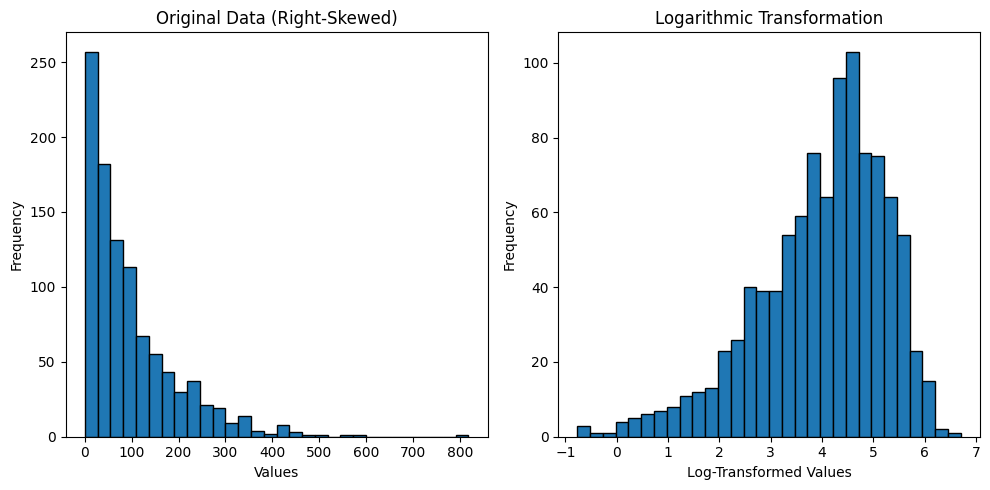

In [9]:
# Create a right-skewed dataset
sales_data = np.random.exponential(scale=100, size=1000)

# Apply logarithmic transformation
log_transformed_data = np.log(sales_data)

# Plot the original and transformed data distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Data (Right-Skewed)')
plt.hist(sales_data, bins=30, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.title('Logarithmic Transformation')
plt.hist(log_transformed_data, bins=30, edgecolor='black')
plt.xlabel('Log-Transformed Values')
plt.ylabel('Frequency')
plt.tight_layout()

The data distribution on the left does not follow a normal distribution with a distinct bell-shaped pattern. Therefore, if you tried to use this data in a statistical test, such as those discussed in Chapter 2, you would be limited in the types of tests you could use. This is because many statistical tests, such as the one-sample t-test, assume that your data come from a normal distribution, and using the test on non-normal data can invalidate the results. However, the log transformation can make our data more like a normal distribution.

**NOTE:** Logarithm transformations are only applicable to positive values. If the data contains zero or negative values, you can add a constant to the data before applying the transformation.

### 3.2. Power transformations
A power transformation is a family of data transformation techniques that involve raising each data
point to a power (exponent). Different power values result in different transformations, allowing flexibility in shaping the distribution. Common power transformations include square root transformation (power = 0.5), cube root transformation (power = 1/3), and reciprocal transformation (power = -1).

Power transformations are useful for stabilizing variance, reducing skewness, and making the data distribution more symmetrical. This is particularly beneficial for linear modeling.

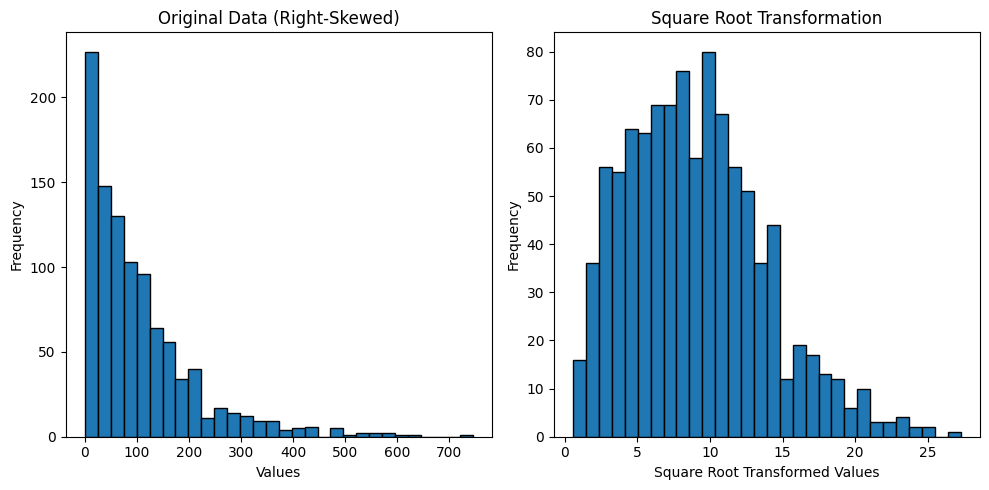

In [10]:
# Create a right-skewed dataset
sales_data = np.random.exponential(scale=100, size=1000)

# Apply square root transformation
sqrt_transformed_data = np.sqrt(sales_data)

# Plot the original and transformed data distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Data (Right-Skewed)')
plt.hist(sales_data, bins=30, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.title('Square Root Transformation')
plt.hist(sqrt_transformed_data, bins=30, edgecolor='black')
plt.xlabel('Square Root Transformed Values')
plt.ylabel('Frequency')
plt.tight_layout()


As a result of the transformation, the data becomes less skewed, and the distribution moves closer to a normal distribution.

### 3.3. Box-Cox transformations
A Box-Cox transformation is a family of power transformations that are designed to stabilize variance
in our dataset so it closely resemples a normal distribution. The Box-Cox equation can be seen here:

$$y(\lambda) = \begin{cases} \frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\ \log(y) & \text{if } \lambda = 0 \end{cases}$$

*y* is the original data and *λ* is the transformation parameter. The transformed data is *y(λ)*.

The Box-Cox family of transformations also includes both the logarithmic (λ=0) and square root (λ=0.5) transformations as special cases.

**Limitation:** 
* If **interpretation** is your goal, then the Box-Cox transformation may be a poor choice. If lambda is a non-zero number, then the transformed target variable may be more difficult to interpret than if we simply applied a log transform.
* This test only works for positive data. It does not work for data that contains zero or negative values.

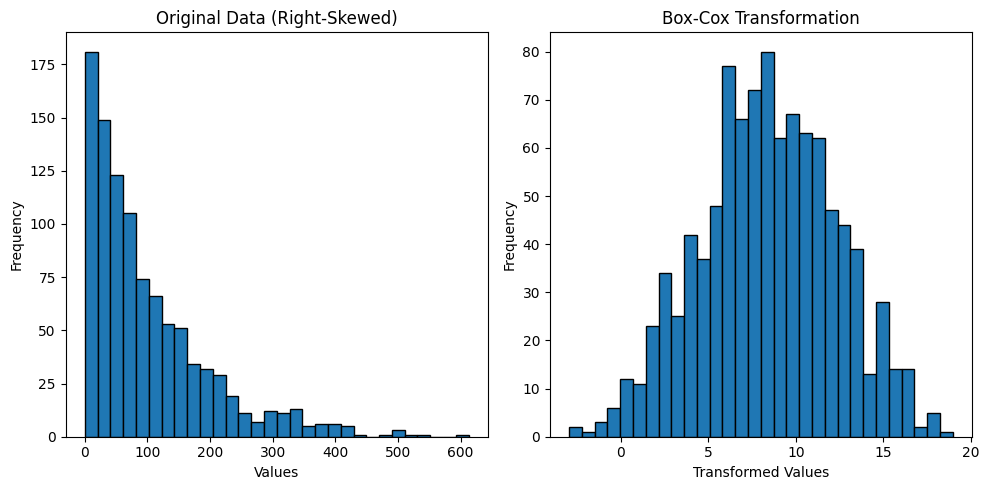

In [11]:
# Create a right-skewed dataset
original_data = np.random.exponential(scale=100, size=1000)

# Apply Box-Cox transformation
transformed_data, lambda_value = boxcox(original_data)

# Plot the original and transformed data distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Data (Right-Skewed)')
plt.hist(original_data, bins=30, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.title('Box-Cox Transformation')
plt.hist(transformed_data, bins=30, edgecolor='black')
plt.xlabel('Transformed Values')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The Box-Cox transformation helps to stabilize the variance and achieve a more symmetric distribution in the transformed data. This plot demonstrates the effectiveness of the Box-Cox transformation in addressing skewness and making data more suitable for certain types of analyses and modeling tasks.

### 3.4. Exponential transformations
Exponential transformations are used to transform data that is highly skewed, where extreme values cause a long tail in the distribution. The exponential function is used to **expand** (instead of compressing it like in log transformation) the range of the data, making it easier to visualize and analyze.

When to use it:
* When the data is highly skewed and the distribution has a long tail
* Whendata or a specific variable exhibits certain characteristics, related to time-to-event or waiting time phenomena
* When dealing with data that follows exponential growth or decay patterns
* When the probability of an event occurring in the next instant is independent of the time that has passed since the last event.

Warning: 
* Data must be positive
* The use a base of e or the natural exponential function, and negative values when exponentiated, which can lead to complex numbers that might not be suitable for certain types of analyses.
* We must be aware of the magnitude of the data values. Exponential transformations can lead to very large values, which could cause overflow in some computational environments.

## 4. Dealing with categorical data
Categorical variables contain discrete values that represent different groups or categories. Effectively preprocessing and engineering these variables is essential to extract valuable insights and enhance the predictive power of machine learning models.

There are several techniques to handle categorical data, here we will see three of them:
* **One-hot encoding** --> use when dealing with categorical variables with low cardinality and no inherent ordinality
* **Label encoding** --> use when dealing with categorical variables with inherent ordinality.
* **Target encoding** --> use when dealing with categorical variables that show a strong relationship with the target variable. However, one must be cautios to avoid overfitting and data leakage.

### 4.1. One-hot encoding
One-hot encoding is a technique used to convert categorical variables into a binary matrix. Each category is represented as a binary vector, where all elements are zero except for the category element, which is marked as 1.

In [12]:
# Sample dataset
genders = ["Female", "Male", "Non-Binary"]
data = {
    'ID': np.arange(1, 6),
    'Gender': [random.choice(genders) for _ in range(5)]
}

df = pd.DataFrame(data)
df

,ID,Gender
0,1,Female
1,2,Male
2,3,Female
3,4,Female
4,5,Female


In [13]:
# One-hot encode
one_hot_encoded = pd.get_dummies(df['Gender'], columns=['Gender'])
one_hot_encoded = one_hot_encoded.astype(int)

# Add the one-hot encoded columns to the original DataFrame
df_encoded = pd.concat([df, one_hot_encoded], axis=1)
df_encoded

,ID,Gender,Female,Male
0,1,Female,1,0
1,2,Male,0,1
2,3,Female,1,0
3,4,Female,1,0
4,5,Female,1,0


### 4.2. Label encoding
Label encoding is a technique used to convert categorical variables into numerical labels. Each category is assigned a unique integer value, starting from 0.

Label encoding can be useful when there is an inherent order or ranking among the categories. However, it can introduce unintended ordinality, that may mislead the model.

In [14]:
# Example Data
data = {
    'ID': [1, 2, 3, 4, 5],
    'Color': ['Red', 'Blue', 'Green', 'Red', 'Green']
}
# Create DataFrame
df = pd.DataFrame(data)

# Perform Label Encoding
unique_colors = df['Color'].unique()
color_mapping = {color: i for i, color in enumerate(unique_colors)}
df['Color_LabelEncoded'] = df['Color'].map(color_mapping)
df

,ID,Color,Color_LabelEncoded
0,1,Red,0
1,2,Blue,1
2,3,Green,2
3,4,Red,0
4,5,Green,2


### 4.3. Target encoding
Target encoding, also known as mean encoding, is a technique that leverages the target variable’s information to transform categorical features into numeric representations. Instead of replacing the categories with numerical labels, target encoding replaces each category with the average value of the target variable for that category.

Target encoding can be particularly useful when dealing with high-cardinality categorical variables.

In [15]:
# Example Data
data = {
    'ID': [1, 2, 3, 4, 5],
    'City': ['Indianapolis', 'Detroit', 'Chicago', 'Detroit', 'Indianapolis'],
    'Target': [0.8, 0.6, 0.9, 0.7, 0.75]
}
# Create DataFrame
df = pd.DataFrame(data)


#  Group by city and calculate the mean of the target variable
groupedcity = df.groupby('City')
for name, groups in groupedcity:  # names is the name of the group and groups is the data of the group
    print("Group: ", name)                     
    print(groups)

# Perform Target Encoding
city_target_mean = df.groupby('City')['Target'].mean()
df['City_TargetEncoded'] = df['City'].map(city_target_mean)
df

Group:  Chicago
   ID     City  Target
2   3  Chicago     0.9
Group:  Detroit
   ID     City  Target
1   2  Detroit     0.6
3   4  Detroit     0.7
Group:  Indianapolis
   ID          City  Target
0   1  Indianapolis    0.80
4   5  Indianapolis    0.75


,ID,City,Target,City_TargetEncoded
0,1,Indianapolis,0.80,0.775
1,2,Detroit,0.60,0.650
2,3,Chicago,0.90,0.900
3,4,Detroit,0.70,0.650
4,5,Indianapolis,0.75,0.775


## 5. Creating new features or Calculated fields
Feature engineering involves creating new features or calculated fields from the existing data to improve the performance of machine learning models. By combining, transforming, or extracting new information from the raw data, we can create more informative features that capture the underlying patterns and relationships in the data.

There are the various types of calculated fields:

* **Mathematical operations**: Addition, subtraction, multiplication, division, etc. Example: calculating the total revenue by multiplying the quantity sold by the unit price.

* **Aggregating and grouping**: Aggregation involves summarizing data by grouping it based on certain categorical features and computing statistics, such as *sum*, *mean*, *median*, *mode*, *min*, *max*, etc. Example: calculating the average order value for each customer.

* **Time-based calculations**: ommonly used in time-series data or scenarios that include temporal patterns, time lags, rolling averages, and other time-related transformations that can capture trends and seasonality in data. Example: extracting the month and year from the order date.

* **Interaction terms and polynomial features**: important for capturing non-linear relationships between features. Combining features can reveal interactions that significantly impact the target variable. Example: creating interaction terms between two features, such as multiplying the age and income of a customer.

* **Text and NLP-based calculations**: For datasets containing text data, feature engineering techniques
using Natural Language Processing (NLP) can come in handy. This includes text vectorization, text extraction, concatenation, word counts, and a host of other NLP transformations to derive meaningful features from textual information.

* **Domain-specific calculations**: Domain-specific feature engineering is extremely common and what makes data scientists stand out. Expert knowledge plays a crucial role in generating relevant calculated fields. Example: calculating the Body Mass Index (BMI) from the weight and height of a person in a health dataset.

## 6. Feature selection
Feature selection is the process of selecting a subset of relevant features from the original set of features to improve the model’s performance. It helps reduce overfitting, improve model interpretability, and reduce computational complexity.

In this section, we will explore scenarios where using all available features can lead to the “curse of dimensionality” and why selecting relevant features is crucial to mitigate this issue.

Methods for feature selection:
* **Filter methods**: rank features based on statistical metrics such as correlation, mutual information, or variance. They are computationally efficient and independent of the chosen machine learning model.
    * Information gain
    * Chi-square test
    * Variance Inflation Factor (VIF) and PCA
* **Wrapper methods**: assess feature subsets using a specific machine learning model’s performance as an evaluation metric. They are computationally expensive but can lead to optimal feature subsets for specific models.
    * Recursive Feature Elimination (RFE)
* **Embedded methods**: they incorporate feature selection into the model training process. These methods assess feature importance during model training and eliminate less relevant features automatically.
    * L1 regularization or LASSO
    * Decision trees

Challenge in Filter and Wrapper methods: we need to define
* a threshold or a stopping criterion to determine the optimal number of features to select.
* or how large of a performance change they we willing to accept.

There isn’t a universal answer to the question of how to set a threshold. We should think about how costs to gather and store our data.

### 6.1. Filter methods
Filter methods rank features based on statistical metrics such as correlation, mutual information, or variance. They are computationally efficient and independent of the chosen machine learning model.

Generally applied during the pre-processing step and are independent of the ML algorithm.

#### 6.1.1. Information gain
Information gain is a statistical metric used to measure the relevance of a feature to the target variable.

In [16]:
# Load the breast cancer dataset
data = load_breast_cancer()

# Separate the features and target variable
X = data.data
y = data.target

# Calculate the information gain for each feature
ig = mutual_info_classif(X, y)

# Create a DataFrame to display the information gain values
ig_variables_df = pd.DataFrame({'Variable': data.feature_names, 'Information Gain': ig})

# Sort the DataFrame by information gain
ig_variables_df.sort_values(by='Information Gain', ascending=False, inplace=True)

# Select the top 5 features with the highest information gain
n_variables = 5
selected_var = ig_variables_df.head(n_variables)
selected_var

,Variable,Information Gain
22,worst perimeter,0.476407
23,worst area,0.463431
20,worst radius,0.453524
7,mean concave points,0.439127
27,worst concave points,0.437775


#### 6.1.2. Chi-square test
The chi-square test is a statistical test used to determine the association between two categorical variables. It measures the difference between the observed and expected frequencies of the categories and calculates the statistical significance of the association.

In [17]:
filepath = "bank/bank.csv"
fullpath = os.path.join(mainpath, filepath)
data = pd.read_csv(fullpath, sep=";")  # Load the data

# PREPROCESSING THE DATA
# Drop some variables to simplify the example
data.drop(["education", "job","poutcome", "day_of_week"], axis=1,inplace=True)  # Drop missing values
# Drop missing values
data = data[(data != 'unknown').all(axis=1)]
# Encode categorical variables
data["marital"] = data["marital"].map({cat: i for i, cat in enumerate(data['marital'].unique())})
data["contact"] = data["contact"].map({cat: i for i, cat in enumerate(data['contact'].unique())})
data["month"] = data["month"].map({cat: i for i, cat in enumerate(data['month'].unique())})
data["default"] = data["default"].apply(lambda x: 0 if x == "no" else 1)
data["housing"] = data["housing"].apply(lambda x: 0 if x == "no" else 1)
data["loan"] = data["loan"].apply(lambda x: 0 if x == "no" else 1)
data["y"] = data["y"].apply(lambda x: 0 if x == "no" else 1)
# Features must be non-negative for chi2: Apply Min-Max scaling to numerical data. (we should have checked for outliers first)
data["age"] = (data["age"] - data["age"].min()) / (data["age"].max() - data["age"].min())
data["duration"] = (data["duration"] - data["duration"].min()) / (data["duration"].max() - data["duration"].min())
data["campaign"] = (data["campaign"] - data["campaign"].min()) / (data["campaign"].max() - data["campaign"].min())
data["pdays"] = (data["pdays"] - data["pdays"].min()) / (data["pdays"].max() - data["pdays"].min())
data["previous"] = (data["previous"] - data["previous"].min()) / (data["previous"].max() - data["previous"].min())
data["emp.var.rate"] = (data["emp.var.rate"] - data["emp.var.rate"].min()) / (data["emp.var.rate"].max() - data["emp.var.rate"].min())
data["cons.price.idx"] = (data["cons.price.idx"] - data["cons.price.idx"].min()) / (data["cons.price.idx"].max() - data["cons.price.idx"].min())
data["cons.conf.idx"] = (data["cons.conf.idx"] - data["cons.conf.idx"].min()) / (data["cons.conf.idx"].max() - data["cons.conf.idx"].min())
data["euribor3m"] = (data["euribor3m"] - data["euribor3m"].min()) / (data["euribor3m"].max() - data["euribor3m"].min())
data["nr.employed"] = (data["nr.employed"] - data["nr.employed"].min()) / (data["nr.employed"].max() - data["nr.employed"].min())

# Show the first 5 rows of the data
data.head() 

,age,marital,default,housing,loan,contact,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.171429,0,0,1,0,0,0,0.133681,0.029412,1.0,0.000000,0.333333,0.269680,0.192469,0.153741,0.512287,0
1,0.300000,1,0,0,0,1,0,0.094977,0.088235,1.0,0.000000,0.937500,0.698753,0.602510,0.956916,0.859735,0
2,0.100000,0,0,1,0,1,1,0.062311,0.000000,1.0,0.000000,1.000000,0.882307,0.376569,0.981179,1.000000,0
4,0.414286,0,0,1,0,0,2,0.015921,0.000000,1.0,0.000000,0.687500,0.389322,0.368201,0.806349,0.877883,0
5,0.200000,1,0,0,0,0,3,0.035136,0.058824,1.0,0.333333,0.479167,0.778644,0.556485,0.056463,0.000000,0


<Axes: >

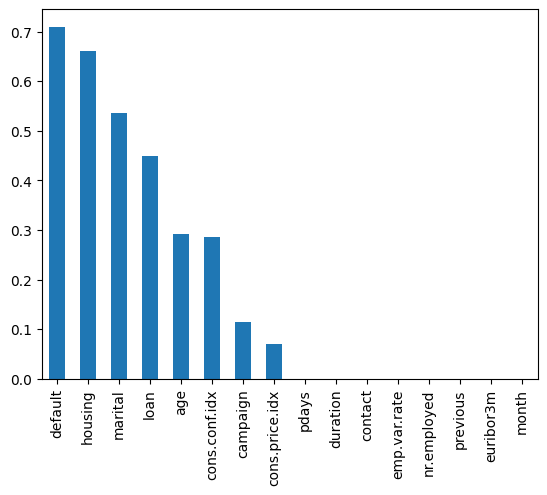

In [18]:
X = data.drop('y',axis=1)
y = data['y']  # has the client subscribed a term deposit? (binary: "yes"=1, "no"=0)

chi_score, pvalue = chi2(X,y)

p_values = pd.Series(pvalue, index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

p_values.plot.bar()

From lesson 2, we know that variables with higher p-values are less likely to be associated with the target variable. Therefore, we can use the p-values from the chi-square test to rank the features based on their association with the target variable.

In [19]:
# Select the top 5 features with the highest information gain
n_variables = 5
selected_var = p_values.head(n_variables)
# Get variables names
selected_var_names = selected_var.index
selected_var_names

Index(['default', 'housing', 'marital', 'loan', 'age'], dtype='object')

#### 6.1.3. Variance Inflation Factor (VIF) and PCA 
Collinear features (or multicollinear features for 3 or more variables) refer to variables that are highly correlated with each other. Such features can introduce redundancy in the dataset and impact model interpretability.

Variance Inflation Factor (VIF) can be used to detect collinearity between features. A high VIF score for a feature indicates strong multicollinearity, while a VIF close to 1 indicates no collinearity. To address collinearity, data scientists may choose to remove one of the highly correlated features or perform dimensionality reduction, using techniques such as PCA to create uncorrelated principal components.

We will talk about PCA in section 8.

**EXAMPLE:** We will use the fetch_california_housing to predict the median house value for California districts, based on information such as the average number of rooms per household and the median house age.

In [20]:
# Load the California Housing dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Function to calculate VIF for each feature
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Calculate VIF for the entire feature set
vif = calculate_vif(X)
print(vif)

      Feature         VIF
0      MedInc   11.511140
1    HouseAge    7.195917
2    AveRooms   45.993601
3   AveBedrms   43.590314
4  Population    2.935745
5    AveOccup    1.095243
6    Latitude  559.874071
7   Longitude  633.711654


In [21]:
# Filter features with VIF greater than a threshold
threshold = 10
high_vif_features = vif[vif['VIF'] > threshold]
high_vif_features

,Feature,VIF
0,MedInc,11.511140
2,AveRooms,45.993601
3,AveBedrms,43.590314
6,Latitude,559.874071
7,Longitude,633.711654


### 6.2. Wrapper methods
Wrapper methods assess feature subsets using a specific machine learning model’s performance as an evaluation metric. 

They are computationally expensive but can lead to optimal feature subsets for specific models.

Lets see an example of a wrapper method:

#### 6.2.1. Recursive Feature Elimination (RFE)
Recursive Feature Elimination (RFE) is a wrapper method that recursively removes features from the dataset based on their importance. It trains the model on the full feature set and ranks the features based on their importance. The least important features are then removed, and the model is retrained on the reduced feature set. This process is repeated until the desired number of features is reached.

RFE is particularly useful when a machine learning model provides feature importance rankings, such
as decision trees or linear regression.

In [22]:
# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

print(data.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [23]:
# Create a logistic regression model
# The ML model we use in this example is logistic regression (we'll cover this in more detail in the next chapter)
model = LogisticRegression()

# Initialize RFE and specify the number of features to select
rfe = RFE(model, n_features_to_select=2)
# Fit RFE on the data 
rfe.fit(X, y)

# Get the selected features
selected_features = rfe.support_
print('Selected Features:', selected_features)

# Get the feature ranking
feature_ranking = rfe.ranking_
print('Feature Ranking:', feature_ranking)

# Get the names of the selected features
selected_features_names = [data.feature_names[id] for id in np.where(selected_features)[0]]
print

Selected Features: [False False  True  True]
Feature Ranking: [3 2 1 1]


c:\Users\tesal\miniconda3\envs\ds-training\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<function print>

We use an instance of the RFE function to wrap our logistic model in. We state that we want to select the top two features in the dataset.

### 6.3. Embedded methods
Embedded methods incorporate feature selection into the model training process. These methods assess feature importance during model training and eliminate less relevant features automatically.

#### 6.3.1. L1 regularization or LASSO
L1 regularization, also known as the Least Absolute Shrinkage and Selection Operator (LASSO), is a statistical method that uses a penalty term (regularization) to automatically select features in machine learning models during training.

In the LASSO, the linear regression coefficients are penalized based on the absolute values of the coefficients. This penalty encourages some of the coefficients to be exactly zero, effectively
performing feature selection by excluding irrelevant features.

By driving some feature coefficients to zero, the LASSO automatically selects the most relevant features and performs a form of dimensionality reduction.

It helps to enhance model interpretability and generalization while avoiding the risk of overfitting.

Objective function:

$$Cost = \text{MSE} + \alpha \sum |w_i|$$

where:
* MSE is the Mean Squared Error
* α is the regularization parameter
* w_i is the coefficient of the j-th feature


When to use:
* number of features >> number of samples
* when we want to reduce the number of features to improve model interpretability and generalization

**SOME DEFFINITIONS**
* **Linear regression** is a supervised learning algorithm used for predicting a continuous target variable based on one or more input features. It finds the linear relationship between the features and the target variable. In LR, when dealing with high-dimensional data or a dataset with many features, there’s a risk of overfitting.
    * we will see more about linear regression in the next lesson.

* **Overfitting** occurs when the model captures noise in the data and generalizes poorly to new, unseen data. Regularization techniques like L1 regularization can help mitigate this issue by penalizing the coefficients of less important features.

* **Regularization** is a method used to add a penalty term to the linear regression equation. This penalty discourages the model from assigning too much importance to any single feature. Lasso Regression is one such regularization technique.

**EXAMPLE 1:**

We will next import the breast cancer dataset from Scikit-learn with the aim of predicting if a tumor is benign or malignant. This is a classification dataset.

We will train a logistic regression model to classify the tumors. During the training process, we will use L1 regularization to automatically select the most important features and reduce the dimensionality of the dataset.

In [24]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = breast_cancer.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
293,11.85,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,0.1875,0.05715,...,13.06,25.75,84.35,517.8,0.1369,0.17580,0.13160,0.09140,0.3101,0.07007
332,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,...,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,...,23.69,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637
278,13.59,17.84,86.24,572.3,0.07948,0.04052,0.019970,0.012380,0.1573,0.05520,...,15.50,26.10,98.91,739.1,0.1050,0.07622,0.10600,0.05185,0.2335,0.06263
489,16.69,20.20,107.10,857.6,0.07497,0.07112,0.036490,0.023070,0.1846,0.05325,...,19.18,26.56,127.30,1084.0,0.1009,0.29200,0.24770,0.08737,0.4677,0.07623


In [25]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)

# select features using logistic regression as a classifier with the LASSO reg.:
logreg_feature_selector  = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))
logreg_feature_selector .fit(scaler.transform(X_train), y_train)

# find the names of the set of features that will be removed
removed_feats = X_train.columns[(logreg_feature_selector .estimator_.coef_ == 0).ravel().tolist()]

# remove the features from the training and testing sets
X_train_selected = logreg_feature_selector .transform(scaler.transform(X_train))
X_test_selected = logreg_feature_selector .transform(scaler.transform(X_test))

Now we are ready to train the model using the selected features and make predictions.

In [26]:
# Train a logistic regression model on the selected features
logreg = LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10)
logreg.fit(X_train_selected, y_train)
# Make predictions on the test set
y_pred = logreg.predict(X_test_selected)

# Evaluate the model
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.965034965034965


Lets compare the performance of the model with and without feature selection.

In [27]:
# Train a logistic regression model 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.951048951048951


c:\Users\tesal\miniconda3\envs\ds-training\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**EXAMPLE 2:** 

We will next import the california housing dataset from Scikit-learn with the aim of predicting house pricing. This is a regression dataset.

In [28]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)

# Select features using LASSO regression
reg_feature_selector = SelectFromModel(Lasso(alpha=0.03, random_state=10))
reg_feature_selector.fit(scaler.transform(X_train), y_train)

# Get the selected features
X_train_selected = reg_feature_selector.transform(scaler.transform(X_train))
X_test_selected = reg_feature_selector.transform(scaler.transform(X_test))

print(f"Original number of features: {X_train.shape[1]}")
print(f"Selected number of features: {X_train_selected.shape[1]}")

Original number of features: 8
Selected number of features: 6


Now we are ready to make predictions and compare it to the model without feature selection.

In [29]:
# Make predictions
lasso = Lasso(alpha=0.03, random_state=10)  #  feature selection is performed automatically during training
lasso.fit(X_train, y_train) 
y_pred = lasso.predict(X_test)

# Evaluate the model
mse = ((y_pred - y_test) ** 2).mean()
print(f"Mean Squared Error: {mse}")

# Train a linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)

# Evaluate the model
mse = ((y_pred - y_test) ** 2).mean()
print(f"Mean Squared Error (no feature selection): {mse}")

Mean Squared Error: 0.5633885533867017
Mean Squared Error (no feature selection): 0.5404128061709079


#### 6.3.2. Decision trees

Tree-based models, such as **Random Forest** and **Gradient Boosting**, can provide valuable feature importance scores. These scores indicate the relative importance of each feature in predicting the target variable.

Tree-based feature selection uses these importance scores to rank the features and select the best ones. We will talk more about these models in the Machine Learning chapter.

Tree-based feature selection is computationally efficient and applicable to both classification and regression tasks. It is particularly useful for identifying relevant features in datasets with a mix of categorical and numerical variables. In addition, tree-based models can handle nonlinear relationships, making them suitable for datasets with complex interactions between features.

In [30]:
filepath = "apples/apple_quality.csv"
fullpath = os.path.join(mainpath, filepath)
data = pd.read_csv(fullpath)  # Load the data

data.info()  # We have numerical and categorical variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [31]:
data = data.dropna()
X = data.drop(['Quality'], axis = 1)
y = data['Quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 8, test_size = 0.3)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=16, random_state=8)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Get feature importances
importances = clf.feature_importances_
threshold = 0.1  # Play with this threshold to select more or fewer features
selected_features = [feat for feat, imp in zip(X.columns, importances) if imp > threshold]

# Get the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Original number of features: {X_train.shape[1]}")
print(f"Selected number of features: {X_train_selected.shape[1]}")

Original number of features: 8
Selected number of features: 7


In [32]:
# Train a new model using only the selected features
clf_selected = DecisionTreeClassifier(max_depth=16, random_state=8)
clf_selected.fit(X_train_selected, y_train)

# Make predictions on the test set using the model trained with selected features
y_pred_selected_features = clf_selected.predict(X_test_selected)

# Calculate the accuracy of the model with selected features
accuracy_selected_features = accuracy_score(y_test, y_pred_selected_features)
print(f"Accuracy with selected features: {accuracy_selected_features}")

# Make predictions on the test set using the model trained with all features
y_pred_all_features = clf.predict(X_test_scaled)

# Calculate the accuracy of the model with all features
accuracy_all_features = accuracy_score(y_test, y_pred_all_features)
print(f"Accuracy with all features: {accuracy_all_features}")

Accuracy with selected features: 0.8241666666666667
Accuracy with all features: 0.7983333333333333


## 7. Handling imbalanced data
Imbalanced data refers to datasets where one class (the minority class) is significantly underrepresented compared to another class (the majority class). The class imbalance can lead to biased and suboptimal model performance, as models tend to favor the majority class, making accurate predictions for the minority class challenging.

Since models prioritize the majority class, there are serious consequences of imbalanced data on
model training and evaluation.

* Majority class: refers to the class with the most instances in the dataset.
* Minority class: refers to the class with the fewest instances in the dataset.

Some remedies for imbalanced data include the following:
* **Using different evaluation metrics**: Metrics such as precision, recall, F1-score, and area under the receiver operating characteristic curve (AUC-ROC) are better suited for evaluating model performance on imbalanced data.

* **Over-sampling**: This involves generating synthetic samples for the minority class to increase its representation.

* **Under-sampling**: This involves randomly removing samples from the majority class to decrease its dominance.

* **Random under-sampling and over-sampling:** Python offers libraries such as imbalancedlearn to implement this technique.

* **Synthetic minority over-sampling technique (SMOTE):** SMOTE is a popular over-sampling technique that generates synthetic samples by interpolating between neighboring samples of the minority class. You can use SMOTE from the imblearn.over_sampling package in Python.

* **Ensemble methods**: Ensemble methods, such as Random Forest and Gradient Boosting, can handle imbalanced data effectively due to their inherent robustness.

* **Cost-sensitive learning**: approach that assigns different misclassification costs to different classes, guiding a model to prioritize the minority class.

* **Anomaly detection**: Anomaly detection techniques can be useful in handling imbalanced data by identifying and classifying rare instances as anomalies. These algorithms include **Isolation Forest** and **One-Class SVM**.

**EXAMPLE:**

In [33]:
# read iris dataset
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
y = iris.target
data["species"] = y

# Artificially introduce a new column with class imbalance
data['is_medicinal'] = np.random.choice([0, 1], size=data.shape[0], p=[0.95, 0.05])
print(data['is_medicinal'].value_counts())

data.head()

is_medicinal
0    140
1     10
Name: count, dtype: int64


,sepal_length,sepal_width,petal_length,petal_width,species,is_medicinal
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0


* **Random Over-sampling**

In [34]:
X = data.copy()

# Separate the majority and minority classes
majority_class = X[X['is_medicinal'] == 0]
minority_class = X[X['is_medicinal'] == 1]

# Upsample
minority_upsampled = resample(minority_class, replace=True, n_samples=majority_class.shape[0], random_state=42)

# Combine the majority class with the upsampled minority class
balanced_data  = pd.concat([majority_class, minority_upsampled])

# Check the class distribution
balanced_data['is_medicinal'].value_counts()

is_medicinal
0    140
1    140
Name: count, dtype: int64

* **Random Under-sampling**

In [35]:
X = data.copy()

# Separate the majority and minority classes
majority_class = X[X['is_medicinal'] == 0]
minority_class = X[X['is_medicinal'] == 1]

# Upsample
majority_downsampled  = resample(majority_class, replace=False, n_samples=minority_class.shape[0], random_state=42)

# Combine the majority class with the upsampled minority class
balanced_data  = pd.concat([minority_class, majority_downsampled])

# Check the class distribution
balanced_data['is_medicinal'].value_counts()

is_medicinal
1    10
0    10
Name: count, dtype: int64

* **Synthetic Minority Over-sampling Technique (SMOTE)**

In [36]:
X = data.copy()

y = X['is_medicinal']
X = X.drop('is_medicinal', axis=1)

smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

is_medicinal
0    140
1    140
Name: count, dtype: int64

### 7.2. Cross-Validation
Cross-validation is a technique used to evaluate the performance of machine learning models by training and testing on multiple subsets of the dataset. It helps to assess the model’s generalization performance and reduce the risk of overfitting.

We can use cross validation to evaluate the performance of the model on imbalanced data and on the different techniques used to handle it.

There are several types of cross-validation techniques, including:
* **Holding out Cross Validation**
* **K-Fold Cross-Validation**
* **Leave one out Cross Validation** (LOOCV)

In [37]:
X = data.copy()

# we'll use the original data to show how to perform cross-validation
y = X['species']
X = X.drop(['is_medicinal', 'species'], axis=1)

# Build a decision tree classifier. We will talk more about this in the next chapter
model = DecisionTreeClassifier(criterion = 'gini', max_depth=3)

X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


#### 7.2.1. Holding out Cross Validation
Holding out is the traditional approach for cross validation, where the data is simply divided into two parts i.e. the training and the testing part. The data can be divided into 70-30 or 60-40, 75-25 or 80-20, or even 50-50 depending on the use case. During the training phase we would only show the training part of the dataset to the model.

We will then compare the results of the model in the training and testing phase.

<img src="https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/07/15185319/blogs-15-7-2020-02-1024x565.jpg" width="500">

In [38]:
# Splitting data into training and testing data set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

print("x_train: " ,x_train.shape)
print("x_test: " ,x_test.shape)
print("y_train: " ,y_train.shape)
print("y_test: " ,y_test.shape)

# We shall now fit the model only on the training dataset.
model.fit(x_train, y_train)
# Predicting on test data
preds = model.predict(x_test) 
print("Accuracy: ", accuracy_score(y_test,preds)*100)


x_train:  (120, 4)
x_test:  (30, 4)
y_train:  (120,)
y_test:  (30,)
Accuracy:  96.66666666666667


#### 7.2.2. K-Fold Cross-Validation
As there is never enough data to train your model, removing a part of it for validation poses a problem of underfitting. By reducing the training data, we risk losing important patterns/ trends in data set, which in turn increases error induced by bias. So, what we require is a method that provides ample data for training the model and also leaves ample data for validation. K Fold cross validation does exactly that.

<img src="https://www.datasciencecentral.com/wp-content/uploads/2021/10/k-fold_cross_validation_en-1.jpg" width="500">

The whole data is divided into k sets of almost equal sizes. The first set is selected as the test set and the model is trained on the remaining k-1 sets. In the second iteration, the 2nd set is selected as a test set and the remaining k-1 sets are used to train the data. This process continues for all the k sets. At the end we are averaging the outputs of k fitted models to get the accuracy score of the model.

* Advantages:
    * More accurate estimate of out-of-sample accuracy
    * More “efficient” use of data as every observation is used for both training and testing
* Disadvantages:
    * Can be computationally expensive
    * Can be slower than other methods

In [39]:
scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print(scores)
print("Accuracy: ", scores.mean()*100)

[0.96666667 0.96666667 0.93333333 1.         1.        ]
Accuracy:  97.33333333333334


#### 7.2.3. Leave one out Cross Validation (LOOCV)
LOOCV(Leave One Out Cross-Validation) is a type of cross-validation approach in which each observation is considered as the validation set and the rest (N-1) observations are considered as the training set. In LOOCV, fitting of the model is done and predicting using one observation validation set. This process continues ‘N’ times and the average of all these iterations is calculated. This is a special case of K-fold cross-validation in which the number of folds is the same as the number of observations(K = N).

<img src="https://d2mk45aasx86xg.cloudfront.net/image2_11zon_cac3fb4270.webp" width="500">

* Advantages:
    * This method helps to reduce Bias and Randomness.
* Disadvantages:
    * It is computationally expensive
    * LOOCV can lead to high variance in performance estimation because each fold is evaluated on a single data point. Outliers or noisy data can disproportionately influence the results.
    * Not recommended if the dataset contains outliers or non-representative points

In [40]:
# Perform Leave-One-Out cross-validation
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
print("Accuracy: ", scores.mean()*100)

Accuracy:  94.66666666666667


## 8. Reducing dimensionality

Dimensionality reduction is the process of reducing the number of input variables in a dataset. It is a critical step in the data preprocessing pipeline, as it helps to address the “curse of dimensionality” and improve the performance of machine learning models.

The “curse of dimensionality” leads to increased computational complexity and potential overfitting.

Dimensionality reduction methods help to transform data into a lower-dimensional space, enabling easier visualization, improved model performance, and enhanced interpretability.

Methods for dimensionality reduction:
* **Principal Component Analysis (PCA)**
* **Singular Value Decomposition (SVD)**
* **t-Distributed Stochastic Neighbor Embedding (t-SNE)**
* **Autoencoders**

### 8.1. Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a popular dimensionality reduction technique that transforms the original features into a new set of uncorrelated variables (projects data onto orthogonal axes) called principal components. These components capture the maximum variance in the data and are ordered by their importance.

The first principal component represents the direction of the highest variance, the second principal component represents the second highest variance, and so on. By selecting a reduced number of principal components, we can project the data onto a lower-dimensional subspace while retaining the most relevant information.

PCA is widely used for data visualization, feature extraction, and noise reduction. It helps in identifying the main patterns and trends in data, simplifying data representation, and speeding up machine learning algorithms by reducing computational complexity.

**Note:** PCA assumes linearity in the data and may not perform well on complex non-linear relationships.

In [41]:
filepath = "campus-recruitment/Placement_Data_Full_Class.csv"
fullpath = os.path.join(mainpath, filepath)
data = pd.read_csv(fullpath)  # Load the data

data.head() # Show the first 5 rows of the data

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [42]:
df = data.copy()
# Remove missing values
print("Number of rows: ", len(data))
print("Number of rows with missing values: ", df.isnull().sum().sum())  # Check for missing values
df = df.dropna()
# Perform one-hot encoding
categorical_columns = df.columns[df.dtypes == object] # Find all categorical columns
df = pd.get_dummies(df, columns = categorical_columns, drop_first=True)
df.head()

Number of rows:  215
Number of rows with missing values:  67


,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary,gender_M,ssc_b_Others,hsc_b_Others,hsc_s_Commerce,hsc_s_Science,degree_t_Others,degree_t_Sci&Tech,workex_Yes,specialisation_Mkt&HR
0,1,67.00,91.00,58.00,55.0,58.80,270000.0,True,True,True,True,False,False,True,False,True
1,2,79.33,78.33,77.48,86.5,66.28,200000.0,True,False,True,False,True,False,True,True,False
2,3,65.00,68.00,64.00,75.0,57.80,250000.0,True,False,False,False,False,False,False,False,False
4,5,85.80,73.60,73.30,96.8,55.50,425000.0,True,False,False,True,False,False,False,False,False
7,8,82.00,64.00,66.00,67.0,62.14,252000.0,True,False,False,False,True,False,True,True,False


In [43]:
# Create training / test split
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[df.columns != 'salary']],
                                                    df['salary'],
                                                    test_size=0.25,
                                                    random_state=1)

# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Perform PCA
pca = PCA(n_components=5)
# Get new features
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Original number of features: ", X_train.shape[1])
print("Reduced number of features: ", X_train_pca.shape[1])
# Print the explained variance ratio of the five principal components
print("Explained Variance Ratio: ", pca.explained_variance_ratio_)

Original number of features:  15
Reduced number of features:  5
Explained Variance Ratio:  [0.19241983 0.16085737 0.12184033 0.09154508 0.08281544]


PCA is a very interesting statistical technique. To read more about it, you can check the following link: [PCA](https://www.geeksforgeeks.org/principal-component-analysis-pca/#)

### 8.2. Singular Value Decomposition (SVD)
Single Value Decomposition (SVD) is a fundamental matrix factorization technique that plays a key role in PCA. SVD is used to decompose a matrix into three matrices, U, Σ, and Vᵀ. U and Vᵀ are orthogonal matrices, while Σ is a diagonal matrix containing the singular values.

In PCA, SVD is applied to the centered data to obtain the principal components and explained variance.
In Python, we can run SVD like this:

In [44]:
# Sample data
X = np.random.rand(100, 5)

# Center the data
X_centered = X - X.mean(axis=0)

# Perform SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Reduce dimensionality to two dimensions using the first two
X_svd = np.matmul(U[:, :2], np.diag(S[:2]))

print("Original number of variables: ", X.shape[1])
print("Reduced number of variables: ", X_svd.shape[1])

Original number of variables:  5
Reduced number of variables:  2


### 8.3. t-Distributed Stochastic Neighbor Embedding (t-SNE)
t-distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear dimensionality reduction technique used when data has complex non-linear relationships. t-SNE aims to preserve local and global structures in the data.

In [45]:
# Sample data
X = np.random.rand(100, 5)

# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

print("Original number of variables: ", X.shape[1])
print("Reduced number of variables: ", X_tsne.shape[1])

Exception in thread Thread-4:
Traceback (most recent call last):
  File "c:\Users\tesal\miniconda3\envs\ds-training\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\tesal\miniconda3\envs\ds-training\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\tesal\miniconda3\envs\ds-training\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\tesal\miniconda3\envs\ds-training\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\tesal\miniconda3\envs\ds-training\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\tesal\miniconda3\envs\ds-training\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical c

Original number of variables:  5
Reduced number of variables:  2


This code takes our randomly generated data and reduces it to two dimensions. It is important to know as a data scientist that this algorithm needs to compute pair-wise distances for each data point in the dataset. Therefore, the time it takes to run increases with the size of the dataset. So, this may not be a great candidate when you have a large amount of data.

### 8.4. Autoencoders
Autoencoders are neural networks used for unsupervised representation learning and non-linear dimensionality reduction. They consist of an encoder that compresses data into a lower-dimensional
representation and a decoder that reconstructs the data from the compressed representation.

Here is an example of how to use an autoencoder in Python for dimensionality reduction:

We are going to design a model with two layers. The first layer encodes the input data into two dimensions. The last layer decodes that information back.The model attempts to learn a representation, where it first encodes the data and decodes it perfectly. Once the training is done, we can throw away the last layer and only use the encoder portion for dimensionality reduction.

We will talk mpore about neural networks in the following lessons.

In [46]:
X = np.random.rand(100, 5)

# Define the autoencoder architecture
input_layer = Input(shape=(X.shape[1],))  
encoded = Dense(2, activation='relu')(input_layer)  # 2-dimensional encoded representation
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
print(autoencoder.summary())

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Train the autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=32, verbose=0)

# Obtain the lower-dimensional representation (encoder part of the autoencoder)
encoder = Model(input_layer, encoded)
X_autoencoder = encoder.predict(X)

print("Original number of variables: ", X.shape[1])
print("Reduced number of variables: ", X_autoencoder.shape[1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 2)                 12        
                                                                 
 dense_1 (Dense)             (None, 5)                 15        
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
None
4/4 [==============================] - 0s 1ms/step
Original number of variables:  5
Reduced number of variables:  2


## 9. Data transformation pipelines
Data transformation pipelines are a sequence of data processing steps that are applied sequentially to transform raw data into a format suitable for machine learning models. 

Pipelines help automate the data preprocessing workflow, ensuring consistency and reproducibility in the analysis.

In [47]:
# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

df = pd.DataFrame(X, columns=data.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [48]:
# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Create the data transformation task pipeline. In this example, we will use StandardScaler and PCA:
pipeline = Pipeline([ ('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

# 3. Fit and transform the task to the training set:
X_train_transformed = pipeline.fit_transform(X_train, y_train)

# 4. Transform the testing set with the training set task pipeline:
X_test_transformed = pipeline.transform(X_test)